# Linear Regression Project

## NASA Airfoil Pressure Level

Author: Piotr Druzdzel <br>
E-mail: piotr.druzdzel@gmail.com <br>

Data source: UCI Machine Learning Repository <br>
https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise

Data Set Information: <br>
The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. <br>
The span of the airfoil and the observer position were the same in all of the experiments.

Independent variables: <br>
1. Frequency, in Hertzs. <br>
2. Angle of attack, in degrees. <br>
3. Chord length, in meters. <br>
4. Free-stream velocity, in meters per second. <br>
5. Suction side displacement thickness, in meters. <br>

Dependent variable: <br>
6. Scaled sound pressure level, in decibels.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as sk

Quick fix for the dark theme plotting:

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Importing dataset:

In [3]:
df_original = pd.read_csv("airfoil_self_noise.dat", 
                          sep='\t', 
                          names=["Frequency", "AoA", "Chord", "V_inf", "displacement_t", "SPL"], 
                          engine='python')

Making a copy:

In [4]:
df = df_original.copy()

### Data exploration:

Checking the structure:

In [5]:
df

,Frequency,AoA,Chord,V_inf,displacement_t,SPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Basic check for the type of data:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Frequency       1503 non-null   int64  
 1   AoA             1503 non-null   float64
 2   Chord           1503 non-null   float64
 3   V_inf           1503 non-null   float64
 4   displacement_t  1503 non-null   float64
 5   SPL             1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


Routine check for missing values:

In [7]:
df.isnull().sum()

Frequency         0
AoA               0
Chord             0
V_inf             0
displacement_t    0
SPL               0
dtype: int64

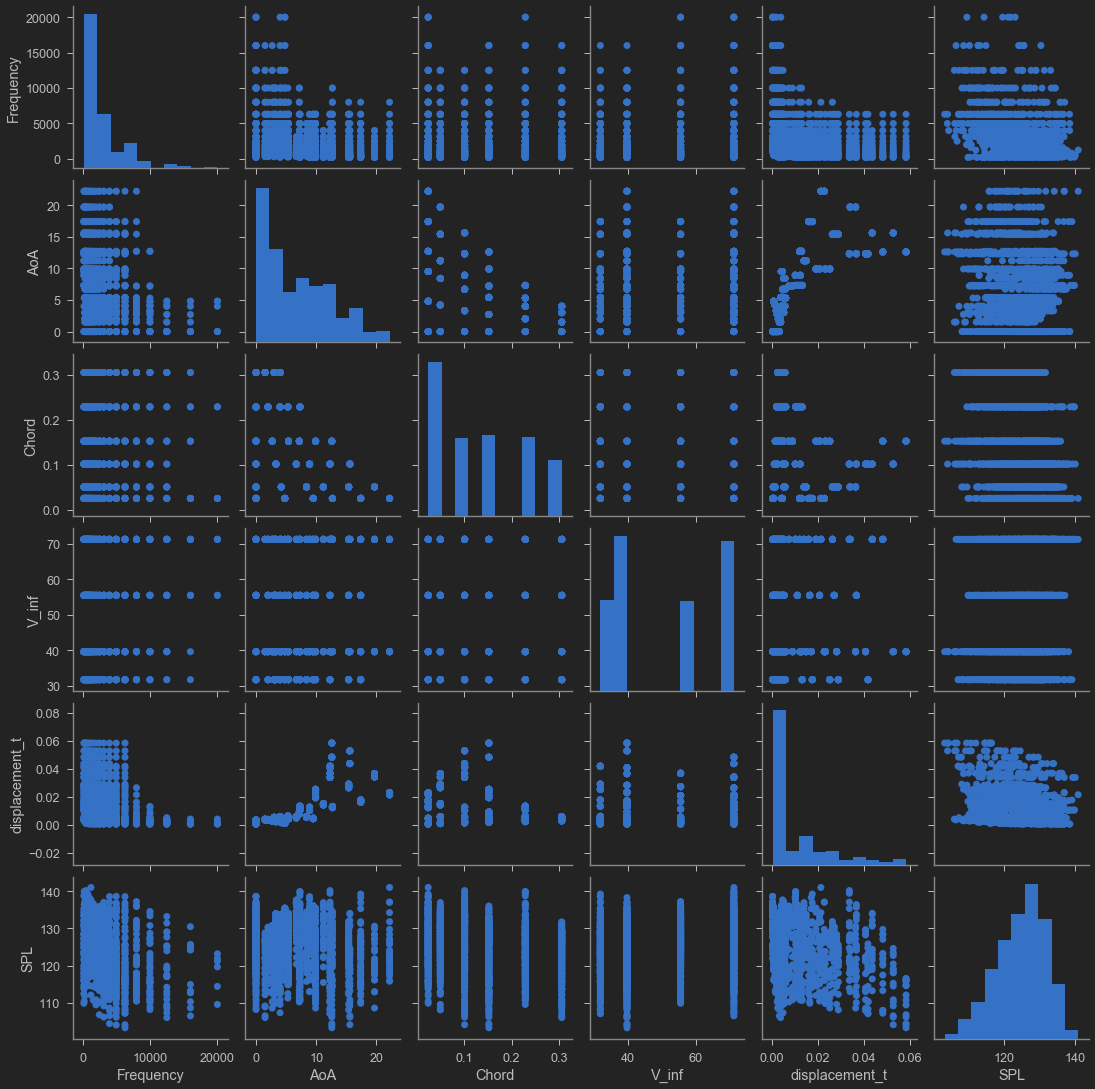

In [8]:
sns.pairplot(df, plot_kws=dict(edgecolor="none"))

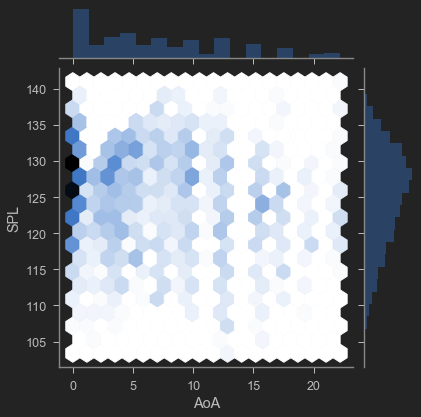

In [9]:
sns.jointplot(x='AoA',y='SPL',data=df, kind='hex');

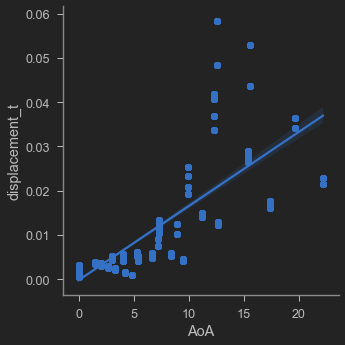

In [10]:
sns.lmplot(x='AoA', y='displacement_t', data=df)

### Train-Test set split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
y = df['SPL']
X = df.drop(['SPL'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling the data
Not a must in regression due to coefficients accounting for scale of numbers but helps in interpretation.

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Simple Linear Regression

### Training the model

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
linear_model = LinearRegression()

In [17]:
linear_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Predictions:

In [18]:
for coefficient in linear_model.coef_:
    print(coefficient)

-4.059447042606654
-2.3667367900365717
-3.2199521491835017
1.5269010028407006
-1.8155901496175622


Predicted Sound Pressure Levels (SPL):

In [19]:
predictions_lin = linear_model.predict(X_test)

Checking how did simple linear model perform (actually, not too good):

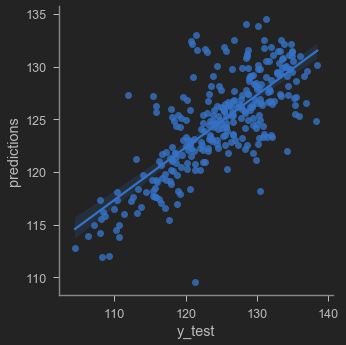

In [20]:
pred_df = pd.DataFrame({'y_test':y_test, 'predictions':predictions_lin})
sns.lmplot(x='y_test', y='predictions', data=pred_df)

### Residuals (y_test - y_pred):

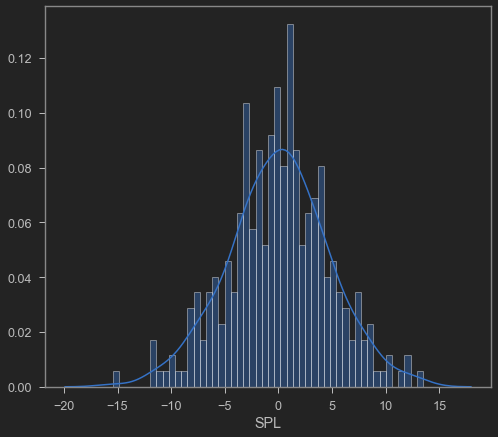

In [21]:
sns.distplot((y_test-predictions_lin),
             bins=50,
             hist_kws=dict(edgecolor="w", linewidth=1));

### Coefficients table:

In [22]:
coeffecients = pd.DataFrame(linear_model.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
Frequency,-4.059447
AoA,-2.366737
Chord,-3.219952
V_inf,1.526901
displacement_t,-1.815590


Frequency, Angle of attack and Chord length have the biggest impact on self-induced noise of NACA 0012 airfoil.

### R2 score:

In [23]:
from sklearn.metrics import r2_score

In [24]:
r2_score(y_test, predictions_lin)

0.5582979754897284

## Choosing the right polynomial degree:
Choosing RootMean Square as an indicator. It penalizes the outliers but less than MSE.

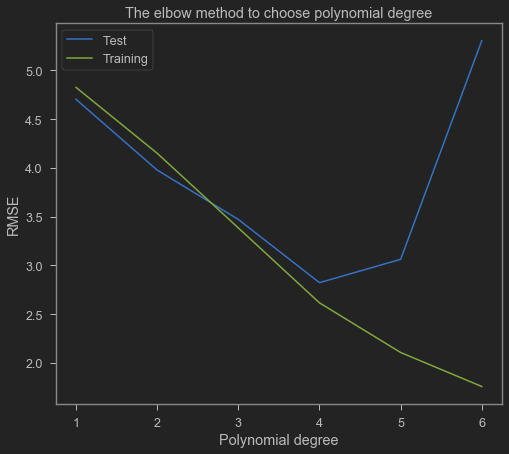

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

RMSE_score = [] #RMSE between the predicted values and the test
training_fit = [] #RMSE between the predicted values and the training set on which the data was trained (expected overfit)

degrees = range(1,7)

for deg in degrees:
    
    poly_reg = PolynomialFeatures(degree=deg)
    
    X_poly_train = poly_reg.fit_transform(X_train)
    X_poly_test  = poly_reg.fit_transform(X_test)
    
    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y_train)
    
    predictions_poly = poly_model.predict(X_poly_test)
    RMSE_poly = np.sqrt(metrics.mean_squared_error(y_test, predictions_poly))
    
    predictions_train = poly_model.predict(X_poly_train)
    fit_poly =  np.sqrt(metrics.mean_squared_error(y_train, predictions_train))
     
    RMSE_score.append(RMSE_poly)
    training_fit.append(fit_poly)
    
plt.plot(degrees, RMSE_score, label='Test')
plt.plot(degrees, training_fit, label='Training')
plt.title('The elbow method to choose polynomial degree')
plt.xlabel('Polynomial degree')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Polynomial Linear Regression:

In [27]:
poly_reg = PolynomialFeatures(degree=4)

X_poly_train = poly_reg.fit_transform(X_train)
X_poly_test  = poly_reg.fit_transform(X_test)

In [28]:
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
predictions_poly = poly_model.predict(X_poly_test)

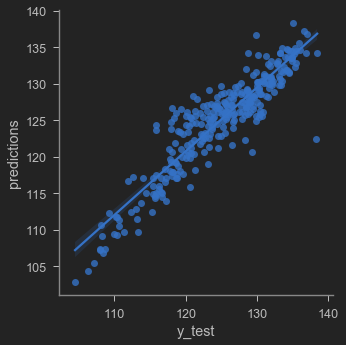

In [30]:
pred_poly_df = pd.DataFrame({'y_test':y_test, 'predictions':predictions_poly})
sns.lmplot(x='y_test', y='predictions', data=pred_poly_df)

### Residuals (y_test - y_pred):

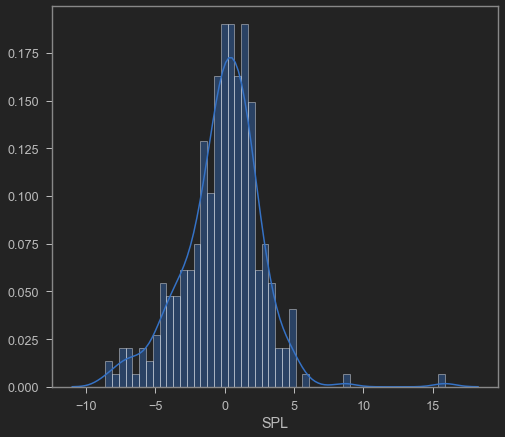

In [31]:
sns.distplot((y_test-predictions_poly),
             bins=50,
             hist_kws=dict(edgecolor="w", linewidth=1));

### Coefficients table:

In [32]:
poly_model.coef_

array([ 3.34600886e-10, -1.16139662e+01, -1.17337302e+02, -1.51778287e+01,
        9.84348626e+00,  9.35389535e+01,  2.02991946e+00, -5.47907116e+00,
        2.72876110e+00,  3.06638178e-01, -7.07221644e-01,  4.93909480e+01,
       -9.13410229e+01, -9.91634957e+00, -2.27161383e+02, -1.73257688e+01,
        2.81498964e+00,  4.70212507e+01, -3.87344258e+00,  1.45650240e+01,
        8.26557355e+01,  1.96178172e+00, -1.77566161e+00,  5.41541747e+00,
       -5.20312361e-01,  1.07379183e+01, -1.25271557e+01, -2.17230592e+01,
        9.21851989e-01,  1.75604429e+01, -1.62837702e+00,  2.73199140e-01,
        1.96777419e+01, -2.34702878e-01, -1.12005727e+00, -2.41960845e+00,
        9.18406416e+00,  1.33453947e+02, -7.81096624e+00,  4.12482929e+01,
        6.71089603e+01, -1.57483037e+01, -3.20880651e+02,  5.48146520e+00,
        4.68022704e+00, -6.42588589e+01,  1.55913202e+01, -2.78936532e+00,
       -5.53319294e+01,  2.38897167e+00,  1.64232611e+01,  1.26134302e+02,
        3.47221819e-01, -

### R2 score:

In [33]:
r2_score(y_test, predictions_poly)

0.8408682035801864